# Data Augmentation for Covid-19 Classification

## An Introduction to the Study

Allen Chang
29 March 2024

**Abstract**
In early 2019, the novel coronavirus began rapidly spreading around the globe. At the 
time, there was little known about the virus and no known treatment and vaccines. At present, 
much more research has been conducted, and there is much more abundant data for disease 
analysis. Here, I create deep learning models to classify whether a patient has coronavirus based 
on chest x-ray scans. I also experiment with various data augmentation methods to identify 
which one results in best performance. 

**Introduction**
According to the WHO, as of July 2021, there have been approximately 190,833,853 
confirmed Covid-19 cases and 4,100,087 confirmed Covid-19 related deaths [1]. Thus, this is a 
severe worldwide pandemic. With Covid-19 being incredibly widespread, having a quick, 
efficient, and accurate method to determine whether a patient is infected is crucial. Typically,
deep learning models benefit from increased training data. Thus, I will experiment with various 
augmentation methods to increase training data and examine whether they present better model 
performance. 

**Methodology**
In this study, I will utilize a CNN model architecture to identify individuals infected with 
COVID-19. One model will be trained on duplicated normal training data, one model will be 
trained on Gaussian blurred data concatenated with normal training data, and one model will be 
trained on scaled data. I will compare the models using various metrics including F1-score, 
accuracy, AUROC, precision, and recall. 
The data can be found here: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/data

**Expected Results**
I expect the models trained on augmented data to see a statistically significant 
improvement from the model trained on normal training data due to the model being able to 
adapt to natural variation in scans. Nevertheless, I am eager to see which augmentation method
performs better. 
A relatively small sample size may be one limitation. Furthermore, more architectures 
can be tested. More trials can also be done to better assess if there is truly a significant difference 
between augmentation methods. 

**References** [1]	S. U. Rehman, S. U. Rehman, and H. H. Yoo, “COVID-19 challenges and its therapeutics,” Biomed. Pharmacother., vol. 142, p. 112015, Oct. 2021, doi: 10.1016/j.biopha.2021.112015.



**Extra References** The authors of the dataset have asked the following two sources to be cited:
-M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, M. T. Islam, “Can AI help in screening Viral and COVID-19 pneumonia?” IEEE Access, Vol. 8, 2020, pp. 132665 - 132676.
-Rahman, T., Khandakar, A., Qiblawey, Y., Tahir, A., Kiranyaz, S., Kashem, S.B.A., Islam, M.T., Maadeed, S.A., Zughaier, S.M., Khan, M.S. and Chowdhury, M.E., 2020. Exploring the Effect of Image Enhancement Techniques on COVID-19 Detection using Chest X-ray Images. arXiv preprint arXiv:2012.02238.

## Computational Analysis

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing import * 
import cv2
import os
from PIL import Image
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint

### Data Loading and Processing

In [2]:
trainC = '/Users/allenchang/Downloads/CovidDataset/Train/Covid'
trainN = '/Users/allenchang/Downloads/CovidDataset/Train/Normal'

valC = '/Users/allenchang/Downloads/CovidDataset/Val/Covid'
valN = '/Users/allenchang/Downloads/CovidDataset/Val/Normal'

In [3]:
def Xtraintest(dir_path): # Returns images in a format that can be learned
    
    def get_all_files(directory_path): # Retrieves all files in the directory
        all_files = []
        for root, dirs, files in os.walk(directory_path):
            for file in files:
                full_path = os.path.join(root, file)
                all_files.append(full_path)
        return all_files

    def read_image(file_path): # Reads image converting it to array and resizing so all are same size
        img = cv2.imread(file_path)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = cv2.resize(img,(128,128)) # Images were resized to 128 x 128
        return img

    directory_path = dir_path
    file_paths = get_all_files(directory_path)

    image_array = []
    for file_path in file_paths:
        image_array.append(read_image(file_path))
        
    image_array = np.array(image_array)
    
    print(image_array.shape)
    return image_array

def Train_test_split(tC = trainC, tN = trainN, vC = valC, vN = valN): # Returns arrays of train and test, combining infected and healthy
    Xtrain_C = Xtraintest(tC)
    Xtrain_N = Xtraintest(tN)

    X_train = np.concatenate((Xtrain_C, Xtrain_N), axis=0)
    y_train = np.concatenate((np.ones(len(Xtrain_C)), np.zeros(len(Xtrain_N))), axis=0)
    

    Xval_C = Xtraintest(vC)
    Xval_N = Xtraintest(vN)

    X_val = np.concatenate((Xval_C, Xval_N), axis=0)
    y_val = np.concatenate((np.ones(len(Xval_C)), np.zeros(len(Xval_N))), axis=0)
    
    return X_train, y_train, X_val, y_val
    

### Preliminary Analysis 

**Sample Description** As seen below, our training set comprises of 500 Covid positive samples and 1500 Healthy samples. The validation set comprises of 500 Covid positive samples and 1000 Healthy samples. 

In [4]:
X_train, y_train, X_val, y_val = Train_test_split()

(500, 128, 128, 3)
(1500, 128, 128, 3)
(500, 128, 128, 3)
(1000, 128, 128, 3)


In [7]:
def print_image(arr, slicenum, title): # Function shows picture of lung
    slice_0 = arr[slicenum, :, :, 0]
    slice_1 = arr[slicenum, :, :, 1]
    slice_2 = arr[slicenum, :, :, 2]

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # Plot the slices
    axs[0].imshow(slice_0, cmap='gray')
    axs[0].set_title(f"Slice [{slicenum}, :, :, 0]")
    axs[0].axis("off")

    axs[1].imshow(slice_1, cmap='gray')
    axs[1].set_title(f"Slice [{slicenum}, :, :, 1]")
    axs[1].axis("off")

    axs[2].imshow(slice_2, cmap='gray')
    axs[2].set_title(f"Slice [{slicenum}, :, :, 2]")
    axs[2].axis("off")

    fig.suptitle(title, fontsize=14, fontweight="bold")

    plt.show()

### Data Augmentation

In [8]:
def blur_data(X_train): # Function performs Gaussian blur using sigma value of 1.25
    blurred_images = []
    for image in X_train:
        blurred_image = np.empty_like(image)
        for depth_slice in range(image.shape[2]):
            blurred_slice = cv2.GaussianBlur(image[:, :, depth_slice], (5, 5), 1.05)

            blurred_image[:, :, depth_slice] = blurred_slice

        blurred_images.append(blurred_image)


    blurred_images = np.array(blurred_images)
    augmented_X_train = np.concatenate((X_train, blurred_images), axis=0)
    
    print_image(blurred_images, 600, "Slice of Blurred Healthy Lung")
    print_image(blurred_images, 0, "Slice of Blurred Covid Lung")

    return augmented_X_train

In [9]:
def scale_data(X_train): # Functions scales the data making it 5% bigger
    scaled_images = []
    for image in X_train:
        scaled_image = np.empty_like(image)
        for depth_slice in range(image.shape[2]):
            center = (image.shape[1] // 2, image.shape[0] // 2)
            rotation_matrix = cv2.getRotationMatrix2D(center, 0, 1.02)
            scaled_slice = cv2.warpAffine(image[:, :, depth_slice], rotation_matrix, (image.shape[1], image.shape[0]))
            scaled_image[:, :, depth_slice] = scaled_slice
        scaled_images.append(scaled_image)
        
    scaled_images = np.array(scaled_images)
        
    print_image(scaled_images, 600, "Slice of Scaled Healthy Lung")
    print_image(scaled_images, 0, "Slice of Scaled Covid Lung")

    
    augmented_X_train = np.concatenate((X_train, scaled_images), axis=0)
    return augmented_X_train


**Augmented Images** The images below show the same healthy and covid positive lungs. They can be compared with the blurred and scaled version. A standard deviation of 1.05 was used for the gaussian blur. For the scale augmentation method, the images were zoomed in by 2%. Augmented images were concatenated with unaltered images and shuffled. Our control model has the original 2000 samples (500 Covid + 1500 Healthy) while our augmented models have 4000 samples (500 Covid + 1500 Healthy + 500 Augmented Covid + 1500 Augmented Healthy). 

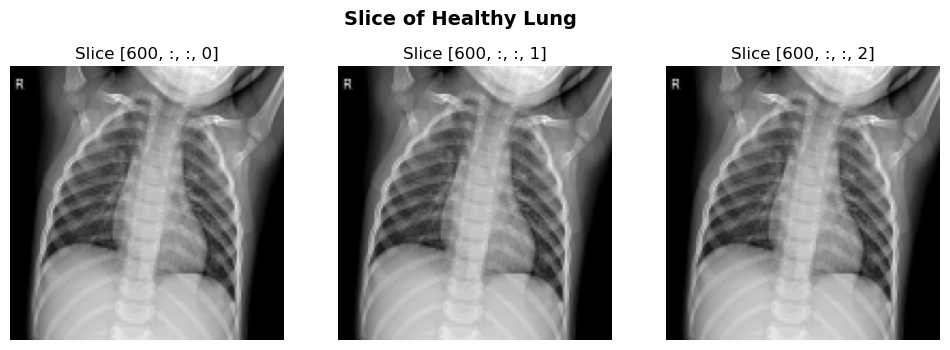

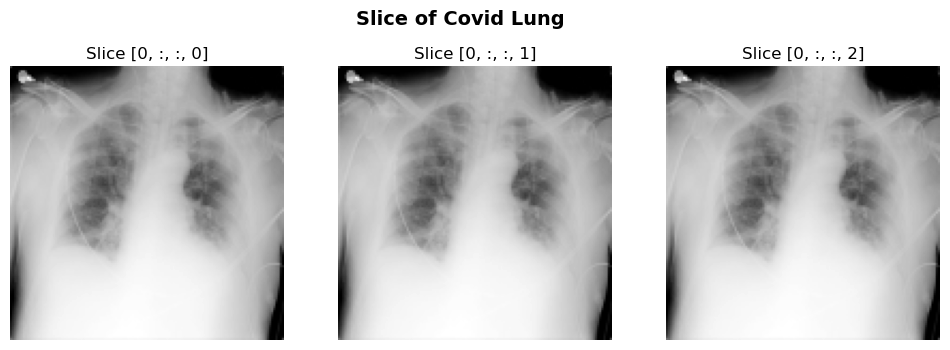

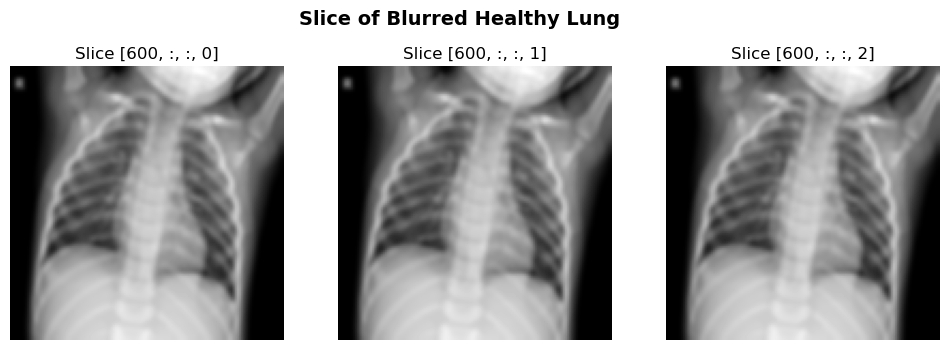

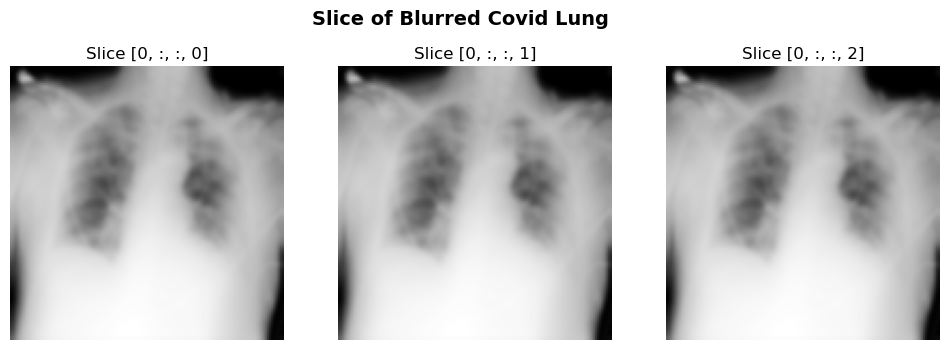

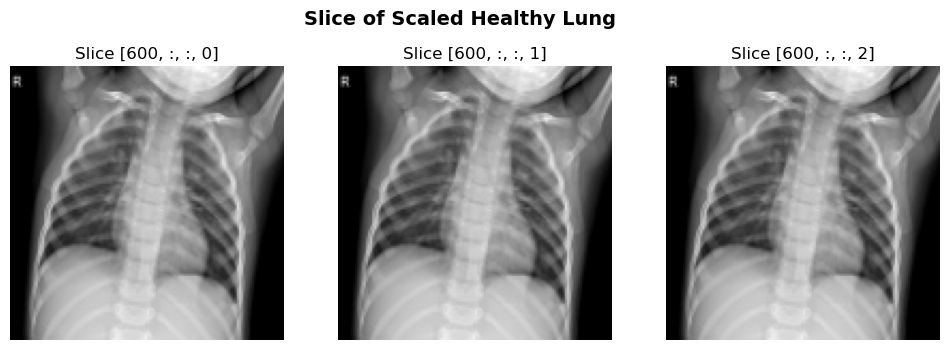

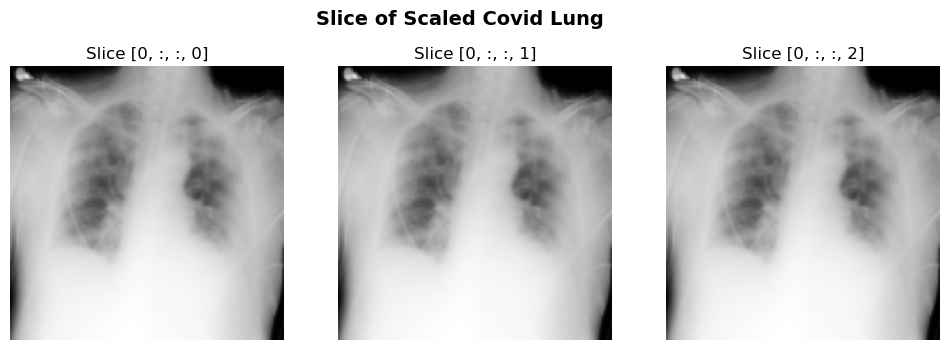

In [10]:
# Show unaltered lungs
print_image(X_train, 600, "Slice of Healthy Lung")
print_image(X_train, 0, "Slice of Covid Lung")

# Create training sets
y_train_cat = np.concatenate((y_train, np.copy(y_train)), axis=0)
X_train_dup = np.concatenate((X_train, np.copy(X_train)), axis=0)
X_train_blur = blur_data(X_train)
X_train_scale = scale_data(X_train)

# Shuffle training sets
idx = np.arange(X_train_dup.shape[0])
np.random.shuffle(idx)

y_train_cat = y_train_cat[idx]
X_train_dup = X_train_dup[idx]
X_train_blur = X_train_blur[idx]
X_train_scale = X_train_scale[idx]


In [11]:
print(X_train_dup.shape)
print(X_val.shape)

(4000, 128, 128, 3)
(1500, 128, 128, 3)


### 2D Convolutional Neural Network Training

**Model** The 2D convolutional neural network model architecture is shown below. The model is trained to 100 epochs, and the epoch with the highest accuracy is saved and used for further analysis. Training and validation loss plots along with accuracy plots for each of the model training are shown below.

In [20]:
def modelArchitecture2D(X_train, model_type, y_t = y_train_cat): # Model architecture
    model = tf.keras.Sequential([

        tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
        
        tf.keras.layers.Conv2D(8, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    checkpoint = ModelCheckpoint(f"/Users/allenchang/Downloads/CovidDataset/best{model_type}_model.keras", monitor='val_accuracy', save_best_only=True, mode='max')
    history = model.fit(X_train, y_t, epochs = 100, batch_size = 16, validation_data=(X_val, y_val), verbose=1, callbacks=[checkpoint])
    
    model.load_weights(f"/Users/allenchang/Downloads/CovidDataset/best{model_type}_model.keras")
    
    return history, model


In [21]:
def train_model(X_t, model_type, y_t = y_train_cat, X_val = X_val, y_val = y_val): # Trains model and plots the model progress
    
    history, model = modelArchitecture2D(X_t, model_type)
    
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_acc) + 1)

    plt.figure(figsize=(10, 6))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Accuracy vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Validation Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'ro', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    test_loss, test_accuracy = model.evaluate(X_val, y_val)
    print(f"Test accuracy: {test_accuracy:.4f}")
    
    return model, history
    

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - accuracy: 0.8781 - loss: 0.3361 - val_accuracy: 0.3820 - val_loss: 1.1771
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9372 - loss: 0.1479 - val_accuracy: 0.5480 - val_loss: 1.1932
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9331 - loss: 0.1531 - val_accuracy: 0.6193 - val_loss: 0.8661
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9480 - loss: 0.1113 - val_accuracy: 0.5367 - val_loss: 0.9800
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9543 - loss: 0.1067 - val_accuracy: 0.7413 - val_loss: 0.7029
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9537 - loss: 0.1028 - val_accuracy: 0.7107 - val_loss: 0.6884
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9627 - loss: 0.0915 - val_accuracy: 0.6880 - val_loss: 0.7438
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9633 - loss: 0

250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.9931 - loss: 0.0184 - val_accuracy: 0.7367 - val_loss: 1.6032
Epoch 51/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.9966 - loss: 0.0143 - val_accuracy: 0.8007 - val_loss: 1.0671
Epoch 52/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.9955 - loss: 0.0108 - val_accuracy: 0.7927 - val_loss: 1.3585
Epoch 53/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - accuracy: 0.9945 - loss: 0.0140 - val_accuracy: 0.7927 - val_loss: 1.3096
Epoch 54/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/step - accuracy: 0.9934 - loss: 0.0174 - val_accuracy: 0.7480 - val_loss: 1.6689
Epoch 55/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.9924 - loss: 0.0238 - val_accuracy: 0.7320 - val_loss: 1.5088
Epoch 56/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.9920 - loss: 0.0283 - val_accuracy: 0.7087 - val_loss: 1.8940
Epoch 57/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.9917 - loss: 0.0260

250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9967 - loss: 0.0072 - val_accuracy: 0.8033 - val_loss: 1.3650
Epoch 100/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9988 - loss: 0.0056 - val_accuracy: 0.7667 - val_loss: 2.0995


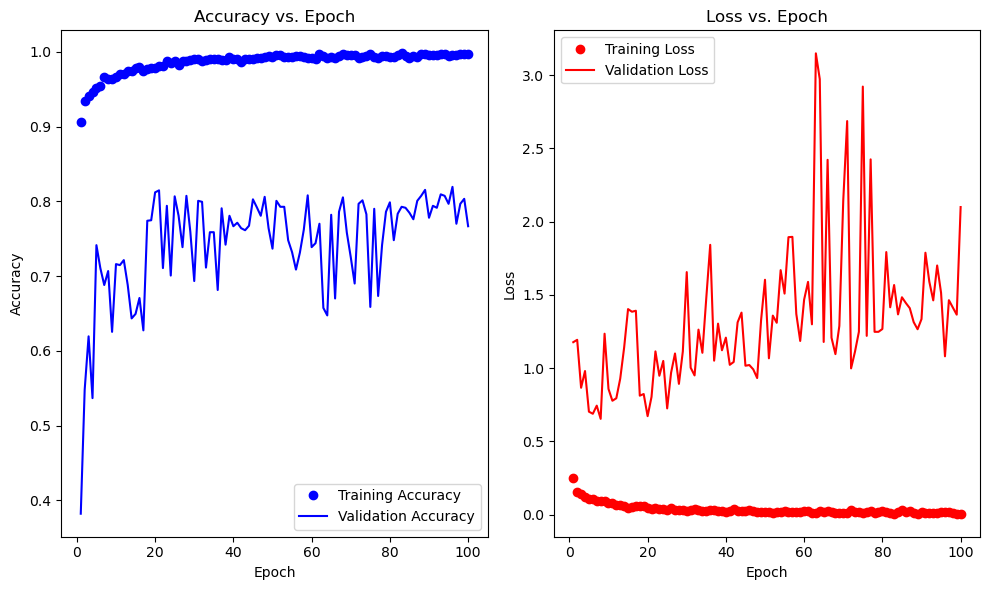

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8026 - loss: 1.0010
Test accuracy: 0.8193


In [22]:
doubleModel, doubleHistory = train_model(X_train_dup, "Duplicated")

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 77ms/step - accuracy: 0.8623 - loss: 0.4091 - val_accuracy: 0.6380 - val_loss: 0.7456
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9169 - loss: 0.2028 - val_accuracy: 0.5313 - val_loss: 0.8621
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9392 - loss: 0.1544 - val_accuracy: 0.4960 - val_loss: 1.4028
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9376 - loss: 0.1501 - val_accuracy: 0.6393 - val_loss: 0.9043
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9500 - loss: 0.1279 - val_accuracy: 0.6973 - val_loss: 0.7351
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9468 - loss: 0.1345 - val_accuracy: 0.7140 - val_loss: 0.6419
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9464 - loss: 0.1120 - val_accuracy: 0.6280 - val_loss: 1.1774
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9515 - loss: 0

250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.9886 - loss: 0.0285 - val_accuracy: 0.7680 - val_loss: 1.3406
Epoch 51/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.9931 - loss: 0.0210 - val_accuracy: 0.7520 - val_loss: 1.5597
Epoch 52/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 78ms/step - accuracy: 0.9939 - loss: 0.0223 - val_accuracy: 0.7440 - val_loss: 1.3983
Epoch 53/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9913 - loss: 0.0284 - val_accuracy: 0.7553 - val_loss: 1.3562
Epoch 54/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9916 - loss: 0.0204 - val_accuracy: 0.7567 - val_loss: 1.5492
Epoch 55/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9903 - loss: 0.0282 - val_accuracy: 0.7440 - val_loss: 1.3852
Epoch 56/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9936 - loss: 0.0217 - val_accuracy: 0.7727 - val_loss: 1.5163
Epoch 57/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9915 - loss: 0.0241

250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9968 - loss: 0.0099 - val_accuracy: 0.7727 - val_loss: 1.9459
Epoch 100/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9930 - loss: 0.0212 - val_accuracy: 0.7707 - val_loss: 1.7813


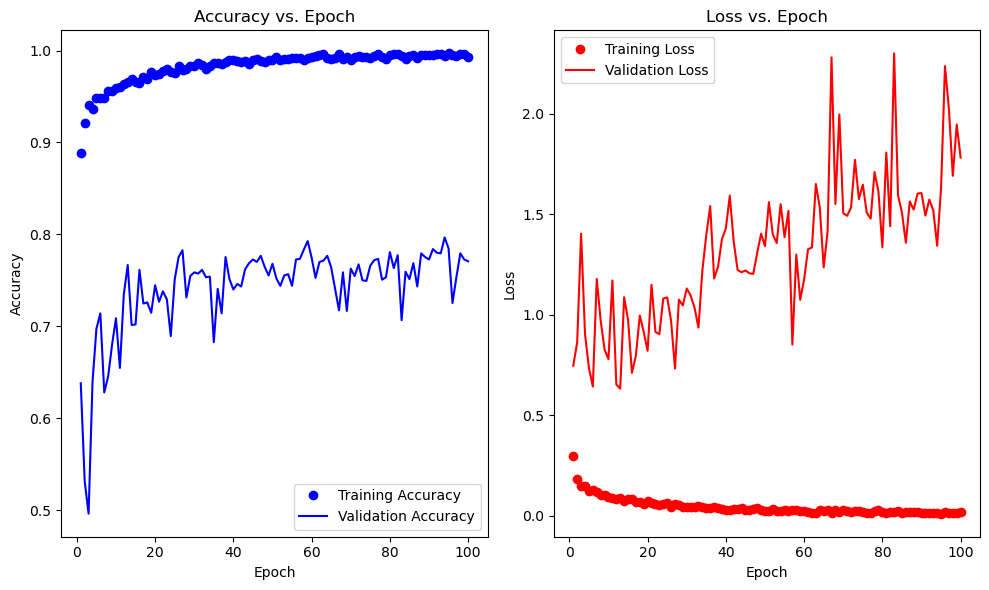

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7518 - loss: 1.3898
Test accuracy: 0.7967


In [23]:
blurModel, blurHistory = train_model(X_train_blur, "Blurred")

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.8594 - loss: 0.4080 - val_accuracy: 0.6667 - val_loss: 0.9680
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9259 - loss: 0.1720 - val_accuracy: 0.7127 - val_loss: 0.7004
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9321 - loss: 0.1469 - val_accuracy: 0.7340 - val_loss: 0.5974
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9452 - loss: 0.1211 - val_accuracy: 0.7027 - val_loss: 0.7072
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9524 - loss: 0.1210 - val_accuracy: 0.7147 - val_loss: 0.6542
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9565 - loss: 0.1107 - val_accuracy: 0.7613 - val_loss: 0.6008
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9627 - loss: 0.0892 - val_accuracy: 0.7213 - val_loss: 0.7334
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9579 - loss: 0

250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 155ms/step - accuracy: 0.9880 - loss: 0.0362 - val_accuracy: 0.7507 - val_loss: 1.6036
Epoch 51/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 131ms/step - accuracy: 0.9922 - loss: 0.0298 - val_accuracy: 0.7607 - val_loss: 1.6209
Epoch 52/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 95ms/step - accuracy: 0.9895 - loss: 0.0304 - val_accuracy: 0.7753 - val_loss: 1.4633
Epoch 53/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9881 - loss: 0.0243 - val_accuracy: 0.7167 - val_loss: 2.3866
Epoch 54/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9948 - loss: 0.0208 - val_accuracy: 0.7213 - val_loss: 1.6182
Epoch 55/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9859 - loss: 0.0421 - val_accuracy: 0.7167 - val_loss: 1.7766
Epoch 56/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9932 - loss: 0.0211 - val_accuracy: 0.7853 - val_loss: 1.2999
Epoch 57/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9937 - loss: 0.01

250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9936 - loss: 0.0172 - val_accuracy: 0.7780 - val_loss: 1.5092
Epoch 100/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9949 - loss: 0.0123 - val_accuracy: 0.7913 - val_loss: 1.8709


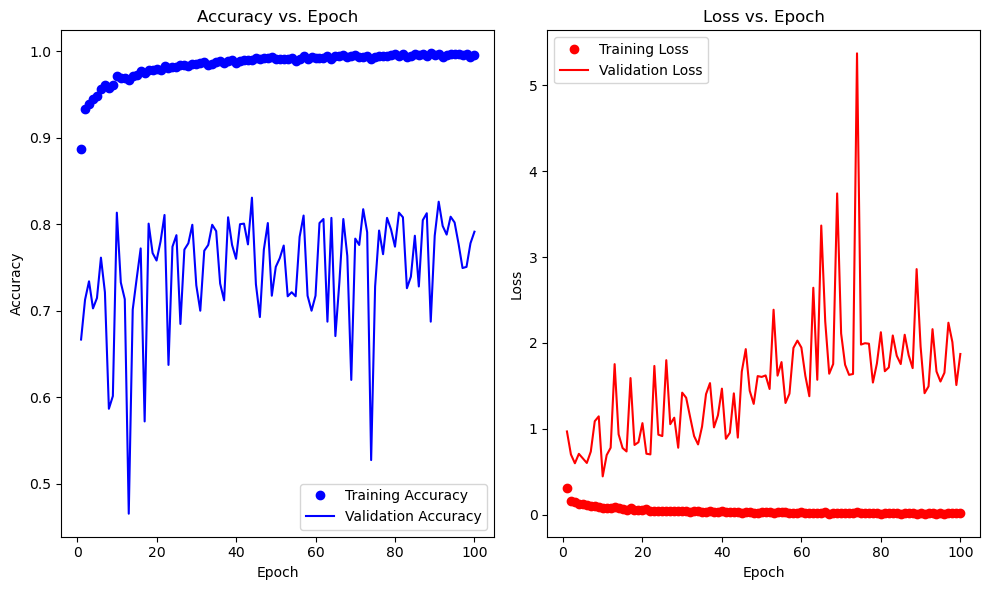

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8528 - loss: 0.6352
Test accuracy: 0.8307


In [24]:
scaleModel, scaleHistory = train_model(X_train_scale, "Scaled")

### Comparative Model Analysis

**Comparing Augmentation Methods** As shown below, our control model and model trained on scaled data have approximately the same AUC values. On the other hand, the model trained on blurred data has a slightly lower AUC value. Looking at the F1-score, we see a similar performance. The model trained on scaled data has the highest F1-score, followed by the control model and the model trained on blurred data. Similar performances can be seen in the precision and accuracy. In fact, the model trained on scaled data has a precision over 12% higher than the control model. This means that the model trained on scaled data has the highest percentage of truly Covid positive patients out of all the patients predicted to be Covid positive. However, for recall, the control model had slightly better performance followed by the model trained on scaled data and the model scaled on blurred data. This is important to take into account, because claiming that someone does not have Covid when they do can have detrimental impact. While it is difficult to definitively conclude that the model trained on scaled data is better than the control model, it does perform the best on nearly all the metrics tested. It can also be concluded that the Gaussian blur is not an effective augmentation method for these purposes. Nevertheless, it is important to perform analysis with different scaling percentages or standard deviations for Gaussian blur. Thus, this can be an area for further research. 

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


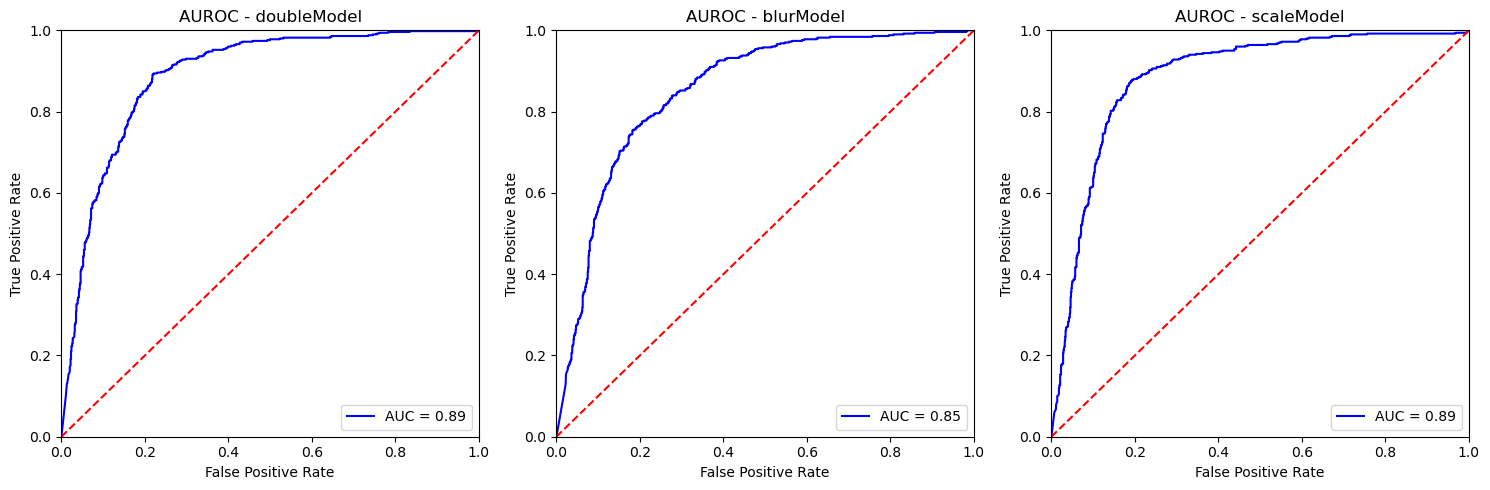

In [25]:
def plot_auroc(X_test = X_val, y_test = y_val, doubleModel = doubleModel, blurModel = blurModel, scaleModel = scaleModel):
    # Predictions for each model
    doublepred = doubleModel.predict(X_test)
    blurpred = blurModel.predict(X_test)
    scalepred = scaleModel.predict(X_test)
    
    # Calculate AUROC for each model
    fpr_double, tpr_double, _ = roc_curve(y_test, doublepred)
    roc_auc_double = auc(fpr_double, tpr_double)
    
    fpr_blur, tpr_blur, _ = roc_curve(y_test, blurpred)
    roc_auc_blur = auc(fpr_blur, tpr_blur)
    
    fpr_scale, tpr_scale, _ = roc_curve(y_test, scalepred)
    roc_auc_scale = auc(fpr_scale, tpr_scale)
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot AUROC for doubleModel
    axs[0].plot(fpr_double, tpr_double, 'b', label=f'AUC = {roc_auc_double:.2f}')
    axs[0].set_title('AUROC - doubleModel')
    axs[0].plot([0, 1], [0, 1], 'r--')
    axs[0].set_xlim([0, 1])
    axs[0].set_ylim([0, 1])
    axs[0].set_ylabel('True Positive Rate')
    axs[0].set_xlabel('False Positive Rate')
    
    # Plot AUROC for blurModel
    axs[1].plot(fpr_blur, tpr_blur, 'b', label=f'AUC = {roc_auc_blur:.2f}')
    axs[1].set_title('AUROC - blurModel')
    axs[1].plot([0, 1], [0, 1], 'r--')
    axs[1].set_xlim([0, 1])
    axs[1].set_ylim([0, 1])
    axs[1].set_ylabel('True Positive Rate')
    axs[1].set_xlabel('False Positive Rate')
    
    # Plot AUROC for scaleModel
    axs[2].plot(fpr_scale, tpr_scale, 'b', label=f'AUC = {roc_auc_scale:.2f}')
    axs[2].set_title('AUROC - scaleModel')
    axs[2].plot([0, 1], [0, 1], 'r--')
    axs[2].set_xlim([0, 1])
    axs[2].set_ylim([0, 1])
    axs[2].set_ylabel('True Positive Rate')
    axs[2].set_xlabel('False Positive Rate')
    
    for ax in axs:
        ax.legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()
    
    return doublepred, blurpred, scalepred

doublepred, blurpred, scalepred = plot_auroc()


In [26]:
def prediction_metrics(doublepred = doublepred, blurpred = blurpred, scalepred = scalepred, y_test = y_val):
    # Round predictions to 0 or 1 for discrete analysis
    doublepred = np.round(doublepred).astype(int)
    blurpred = np.round(blurpred).astype(int)
    scalepred = np.round(scalepred).astype(int)

    print(f"The f1-score for the Control Model is {f1_score(doublepred, y_test)}")
    print(f"The f1-score for the Model trained on Blurred data is {f1_score(blurpred, y_test)}")
    print(f"The f1-score for the Model trained on Scaled data is {f1_score(scalepred, y_test)}")
    print()
    print(f"The precision for the Control Model is {precision_score(doublepred, y_test)}")
    print(f"The precision for the Model trained on Blurred data is {precision_score(blurpred, y_test)}")
    print(f"The precision for the Model trained on Scaled data is {precision_score(scalepred, y_test)}")
    print()
    print(f"The recall for the Control Model is {recall_score(doublepred, y_test)}")
    print(f"The recall for the Model trained on Blurred data is {recall_score(blurpred, y_test)}")
    print(f"The recall for the Model trained on Scaled data is {recall_score(scalepred, y_test)}")
    print()
    print(f"The accuracy the Control Model is {accuracy_score(doublepred, y_test)}")
    print(f"The accuracy for the Model trained on Blurred data is {accuracy_score(blurpred, y_test)}")
    print(f"The accuracy for the Model trained on Scaled data is {accuracy_score(scalepred, y_test)}")

prediction_metrics()

The f1-score for the Control Model is 0.7421503330161751
The f1-score for the Model trained on Blurred data is 0.7000983284169126
The f1-score for the Model trained on Scaled data is 0.774822695035461

The precision for the Control Model is 0.78
The precision for the Model trained on Blurred data is 0.712
The precision for the Model trained on Scaled data is 0.874

The recall for the Control Model is 0.7078039927404719
The recall for the Model trained on Blurred data is 0.688588007736944
The recall for the Model trained on Scaled data is 0.695859872611465

The accuracy the Control Model is 0.8193333333333334
The accuracy for the Model trained on Blurred data is 0.7966666666666666
The accuracy for the Model trained on Scaled data is 0.8306666666666667


## Concluding Remarks

To accomodate time and memory requirements, datasets were trimmed down and scaled from the original dataset according to the parameters above. Models were also only ran to 100 epochs. However, this seems sufficient, since overfitting can be observed as validation loss increases. Nevertheless, more tests can be performed in the future to determine whether the following augmentation methods truly present a statistically significant difference in performance. Furthermore, as mentioned before, more experimentation with different architectures or hyperparameters may result in better model performance. Model weights are available upon request. 